In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=5000)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

from tensorflow import keras
from tifffile import imsave, imread, imwrite
from keras.models import Input, Model
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,LearningRateScheduler
from tifffile import imwrite

from datagenerator_2D import data_generator
from model_2D_interconnect import make_generator
# from Model_2D_Unet import make_generator
# from Model_2D_RCAN import make_generator

from loss_2D import generator_loss
from skimage import exposure
from skimage.exposure import match_histograms
from skimage.exposure import histogram

1 Physical GPUs, 1 Logical GPUs


In [2]:
patch_size = 256
n_patches =  12
n_channel =  0
augment = False
shuffle = True 
batch_size = 1
add_noise= True
lp = 0.1

GT_image_dr = r'D:\Projects\Denoising-STED\20220913-RPI\comparison with other models\RCAN\Vimentin\train\Average.tif'
lowSNR_image_dr =r'D:\Projects\Denoising-STED\20220913-RPI\comparison with other models\RCAN\Vimentin\train\1frame.tif'

x_train, y_train, x_valid, y_valid = data_generator(GT_image_dr, lowSNR_image_dr, patch_size, n_patches,
                                                    n_channel, threshold = 20,ratio=1.0,lp=lp, augment=augment, shuffle=shuffle,
                                                   add_noise=add_noise)

(13, 1, 2048, 2048)
1872
The training set shape is: (1872, 256, 256, 1)
The validation set shape is: (0, 256, 256, 1)


In [3]:
# tf.image.psnr(x_train[0:100],y_train[0:100],max_val=1.0)

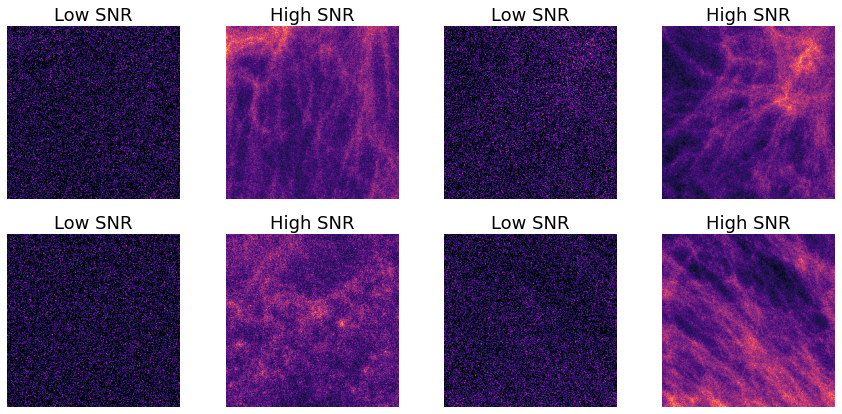

In [4]:
ix = random.sample(range(len(x_train)),4)
fig = plt.figure(figsize=(15,7))

for i in range(4):
    norm_x = np.linalg.norm(x_train[ix[i]], axis=(0, 1))
    fig.add_subplot(2,4, 2*i+1)
    cmap=plt.get_cmap('magma')
    plt.imshow(x_train[ix[i],:,:,0].squeeze(),cmap)
    plt.title('Low SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')
    
    fig.add_subplot(2,4, 2*i+2)
    cmap=plt.get_cmap('magma')
    plt.imshow(y_train[ix[i],:,:,0].squeeze(),cmap)
    plt.title('High SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')

In [5]:
model_save_directory = r"D:\Projects\Denoising-STED\20220913-RPI\comparison-poisson-gaussian\vimentin_gaussian.h5" 
load_model_save_directory = r"D:\Projects\Denoising-STED\20220913-RPI\tubulin-histone\histon_2step.h5" 


n_epochs =  400
gen_lr = 1e-4

# filters =[64,128,256]
filters =[80,160,320]
num_filters = filters[0]
# filters_cab=num_filters/8
filters_cab=num_filters/16

num_RG=3
num_RCAB=8

generator_input = Input((patch_size, patch_size,1))
generator = make_generator(generator_input, filters, num_filters,filters_cab,num_RG,num_RCAB,
                           kernel_shape=3,dropout=0.2)
gen_opt = keras.optimizers.Adam(learning_rate=gen_lr)
generator.compile(optimizer=gen_opt, loss=generator_loss)
# generator.load_weights(load_model_save_directory)



lr_max = 1e-4
lr_min = 1e-6
T = 40
a1 = 0.7
a2 = 0.7
def scheduler(epoch, lr):
    lr_min_i = a1**np.floor((epoch)/T)*lr_min
    lr_max_i = a2**np.floor((epoch)/T)*lr_max
    lr = lr_min_i+0.5*(lr_max_i-lr_min_i)*(1+np.cos(np.pi*np.mod(epoch,T)/(T-1)))
    return lr

# def scheduler(epoch, lr):
#     lr = 1e-9*10**(epoch/20)
#     return lr

# lr_max = 1e-4
# lr_min = 1e-6
# a1 = 0.5
# T = 20
# def scheduler(epoch, lr):
#     if lr>lr_min:
#         lr = gen_lr*(a1**np.floor((epoch+1)/T))
#     else:
#         lr = lr_min
#     return lr

callbacks = [
    LearningRateScheduler(scheduler),
    ModelCheckpoint(filepath=model_save_directory, verbose=1, save_best_only=True, save_weights_only=True)]

# callbacks = [
#     EarlyStopping(patience=30, verbose=1),
#     ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=10),
#     ModelCheckpoint(filepath=model_save_directory, verbose=1, save_best_only=True, save_weights_only=True)]

# callbacks = [LearningRateScheduler(scheduler)]


In [6]:
results = generator.fit(x=x_train,y=y_train, batch_size=batch_size, epochs=n_epochs,verbose=1,
                        callbacks=callbacks,validation_split=0.1)

Epoch 1/400
1684/1684 [==============================] - ETA: 0s - loss: 0.2588 - conv2d_36_loss: 0.1287 - add_39_loss: 0.1301
Epoch 00001: val_loss improved from inf to 0.24144, saving model to D:\Projects\Denoising-STED\20220913-RPI\comparison-poisson-gaussian\vimentin_gaussian.h5
1684/1684 [==============================] - 522s 305ms/step - loss: 0.2588 - conv2d_36_loss: 0.1287 - add_39_loss: 0.1301 - val_loss: 0.2414 - val_conv2d_36_loss: 0.1206 - val_add_39_loss: 0.1209 - lr: 1.0000e-04
Epoch 2/400
1684/1684 [==============================] - ETA: 0s - loss: 0.2478 - conv2d_36_loss: 0.1254 - add_39_loss: 0.1224
Epoch 00002: val_loss did not improve from 0.24144
1684/1684 [==============================] - 580s 344ms/step - loss: 0.2478 - conv2d_36_loss: 0.1254 - add_39_loss: 0.1224 - val_loss: 0.2472 - val_conv2d_36_loss: 0.1244 - val_add_39_loss: 0.1229 - lr: 9.9839e-05
Epoch 3/400
1684/1684 [==============================] - ETA: 0s - loss: 0.2398 - conv2d_36_loss: 0.1200 - add

KeyboardInterrupt: 